In [1]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
### set data file

data_file = ["2019SPTMC02_swim_162613"]
frame_rate = [300];

#data_file = ["20220609_A_zircon_100L_1", "20220609_A_zircon_100L_2"]
#frame_rate = [120, 120];

figs_path = "figure"
if not os.path.exists(figs_path):
    os.mkdir(figs_path)

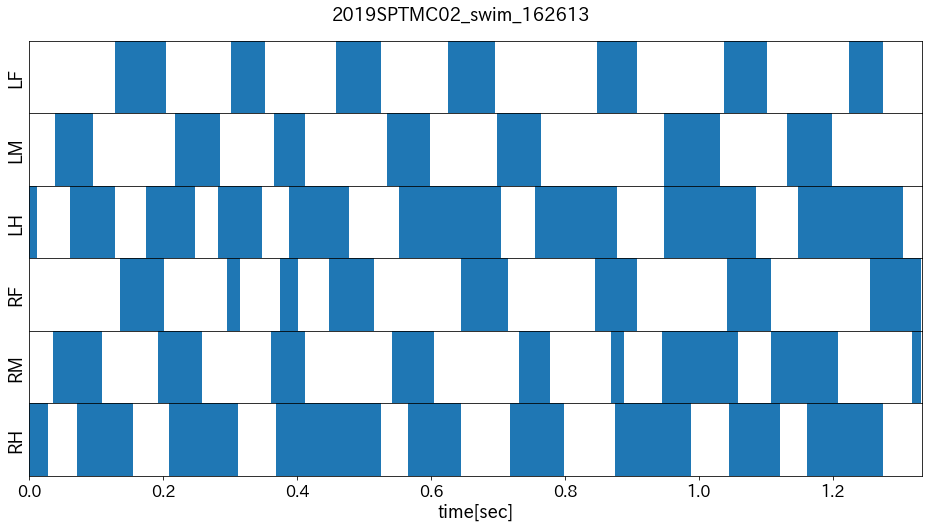

In [3]:
legs = ["LF", "LM", "LH", "RF", "RM","RH"]
nlegs = len(legs)


phase_diff = np.empty((nlegs, nlegs, 0))

for f, rate in zip(data_file, frame_rate):
    dt = 1/rate;
    
    df  = pd.read_csv("data/" + f + ".csv", index_col=0)

    
    z_press = df.values
    
    total_step =df.shape[0]
    t  = np.arange(0, total_step*dt,dt)

    fig = plt.figure(figsize = (16, 8))
    plt.subplots_adjust(hspace=0.0)

    
    for l in range(nlegs):
        ax=fig.add_subplot(6, 1, l+1)
        ax.bar(t, z_press[:,l], width=dt)
        ax.set_xlim(0, total_step*dt)
        ax.set_ylim(0, 1)
        ax.tick_params(labelleft=False)
        ax.tick_params(left=False)
        ax.set_ylabel(legs[l],fontsize=18)
        
        if l != nlegs-1:
            ax.tick_params(labelbottom=False)
            ax.tick_params(bottom=False)
        else:
            ax.set_xlabel("time[sec]",fontsize=18)
            ax.tick_params(axis='x', labelsize=16)

    plt.savefig(figs_path + "/gait_chart_"+f+".pdf", bbox_inches="tight",pad_inches=0.00)
    plt.suptitle(f, fontsize=18, y=0.94)
    plt.show()
    
    l_touch = np.zeros(nlegs);
    n_touch = np.zeros(nlegs);
    l_leave = np.zeros(nlegs);
    n_leave = np.zeros(nlegs);

    
    last_touch = np.zeros((total_step,nlegs));
    next_touch = np.zeros((total_step,nlegs));

    last_leave = np.zeros((total_step,nlegs));
    next_leave = np.zeros((total_step,nlegs));
    
    period = np.zeros((total_step, nlegs))
    phase = np.zeros((total_step, nlegs))
    theta_x = np.zeros((total_step, nlegs))
    duty_cycle = np.zeros((total_step, nlegs))
    phase_d = np.zeros(( nlegs, nlegs,total_step))
    
    for s in range(1,total_step):
        for l in range(0,nlegs):
            if z_press[s-1,l] == 0 and z_press[s,l] == 1:
                    l_touch[l] = t[s];
            
            if z_press[total_step-1-s,l]  == 0 and z_press[total_step-s,l] == 1:
                    n_touch[l] = t[total_step-s];
            
            last_touch[s,l] = l_touch[l];
            next_touch[total_step-1-s,l] = n_touch[l]
            
    for s in range(1,total_step):
        for l in range(0,nlegs):
            if z_press[s-1,l] == 1 and z_press[s,l] == 0:
                    l_leave[l] = t[s];
            
            if  z_press[total_step-1-s,l]  == 1 and z_press[total_step-s,l] == 0:
                    n_leave[l] = t[total_step-s];
            
            last_leave[s,l] = l_leave[l];
            next_leave[total_step-1-s,l] = n_leave[l]
            
    for s in range(0,total_step):
        for l in range(0,nlegs):
            if next_touch[s,l] != 0 and last_touch[s,l] != 0:
                period[s,l] = next_touch[s,l] - last_touch[s,l];                                
                phase[s,l] = 2*np.pi*(t[s]-last_touch[s,l])/period[s,l];
                theta_x[s,l] = 2*np.pi*(t[s]-last_touch[s,l])/period[s,l];
            else:
                period[s, l] = np.nan
                phase[s, l] = np.nan
                theta_x[s,l] = np.nan
        
            if z_press[s, l] == 1 and next_touch[s, l] != 0 and last_touch[s,l] != 0 and next_leave[s,l] != 0:
                duty_cycle[s,l] = (next_leave[s,l] - last_touch[s,l]) / (next_touch[s,l] - last_touch[s,l]) 
            
            elif z_press[s,l] == 0 and next_touch[s,l] != 0 and last_touch[s,l] != 0 and last_leave[s,l] != 0:
                duty_cycle[s,l] = (last_leave[s,l] - last_touch[s,l]) / (next_touch[s,l] - last_touch[s,l])
                                                                                        
            else:
                duty_cycle[s,l] = np.nan

        # 脚間の位相差を計算
        for n in range(0,nlegs):
            for i in range(0,nlegs):
                if i != n:
                    if phase[s,n] - phase[s,i] > 0:
                        phase_d[n,i,s] = phase[s,n] - phase[s,i]; 
                    else:
                        phase_d[n,i,s] = 2*np.pi + phase[s,n] - phase[s,i];

        # 各脚の位相をLFを基準に
        for i  in range(0, nlegs):
            if i  > 0:
                if phase[s, 0] - phase[s,i] > 0:
                    theta_x[s,i] = phase[s,0] - phase[s,i];
                    phase[s,i] = phase[s,0] - phase[s,i];
                else:
                    theta_x[s,i] = 2*np.pi + phase[s,0] - phase[s,i];
                    phase[s,i] = 2*np.pi + phase[s,0] - phase[s,i];
         
    
    phase_diff = np.dstack([phase_diff, phase_d])


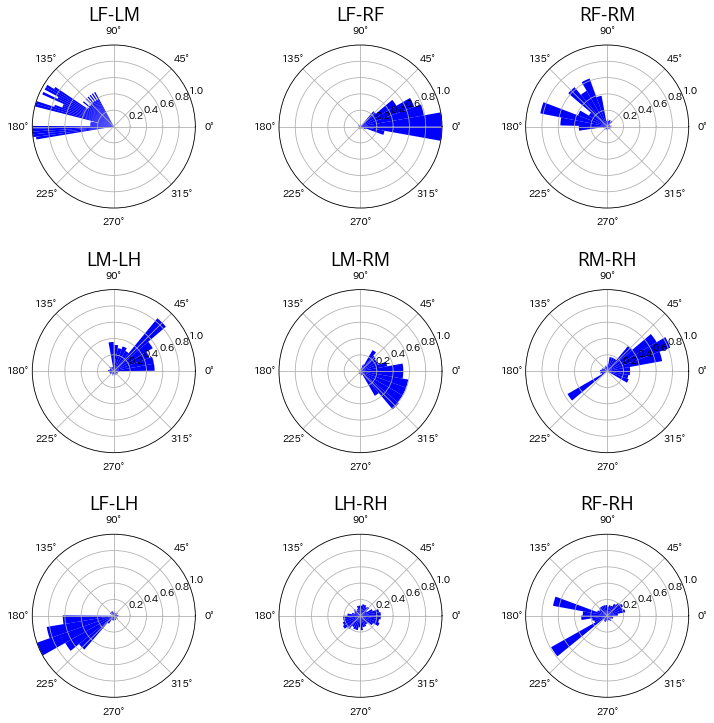

In [4]:
fig = plt.figure(figsize = (12, 12))

plt.subplots_adjust(wspace=0.4, hspace=0.5)
nbins = 36


ax1 = fig.add_subplot(3, 3, 1, projection="polar")
ax1.hist(phase_diff[0,1,:],color="blue", bins=nbins, density=True)
ax1.set_ylim(0,1)
ax1.set_title('LF-LM',fontsize=18)

ax2 = fig.add_subplot(3, 3, 2, projection="polar")
ax2.hist(phase_diff[0,3,:],color="blue", bins=nbins,density=True)
ax2.set_ylim(0,1)
ax2.set_title('LF-RF',fontsize=18)

ax3 = fig.add_subplot(3, 3, 3, projection="polar")
ax3.hist(phase_diff[3,4,:],color="blue", bins=nbins, density=True)
ax3.set_ylim(0,1)
ax3.set_title('RF-RM',fontsize=18)

ax4 = fig.add_subplot(3, 3, 4, projection="polar")
ax4.hist(phase_diff[1,2,:],color="blue", bins=nbins,density=True)
ax4.set_ylim(0,1)
ax4.set_title('LM-LH',fontsize=18)


ax5 = fig.add_subplot(3, 3, 5, projection="polar")
ax5.hist(phase_diff[1,4,:],color="blue", bins=nbins,density=True)
ax5.set_ylim(0,1)
ax5.set_title('LM-RM',fontsize=18)


ax6 = fig.add_subplot(3, 3, 6, projection="polar")
ax6.hist(phase_diff[4,5,:],color="blue", bins=nbins,density=True)
ax6.set_ylim(0,1)
ax6.set_title('RM-RH',fontsize=18)


ax7 = fig.add_subplot(3, 3, 7, projection="polar")
ax7.hist(phase_diff[0,2,:],color="blue", bins=nbins,density=True)
ax7.set_ylim(0,1)
ax7.set_title('LF-LH',fontsize=18)

ax8 = fig.add_subplot(3, 3, 8, projection="polar")
ax8.hist(phase_diff[2,5,:],color="blue", bins=nbins,density=True)
ax8.set_ylim(0,1)
ax8.set_title('LH-RH',fontsize=18)
    
    
ax9 = fig.add_subplot(3, 3, 9, projection="polar")
ax9.hist(phase_diff[3,5,:],color="blue", bins=36,density=True)
ax9.set_ylim(0,1)
ax9.set_title('RF-RH',fontsize=18)

filename = figs_path +"/polarhist"

for name in data_file:
    filename = filename+"_" + name

filename = filename+".pdf"

plt.savefig(filename, bbox_inches="tight",pad_inches=0.00)
plt.show()